# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Operaciones de aprendizaje automático (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Gerardo Rodríguez Hernández
#### 👩‍🏫 **Profesor titular :** Maestro Ricardo Valdez Hernández
#### 👩‍🏫 **Profesor tutor :** Jorge Gonzales Zapata

### 📊 **Fase 1 Proyecto MLOps**

#### 📅 **12 de Octubre de 2025**

### 👥 Equipo 43

* 🧑‍💻 **A01795645 :** Alberto Campos Hernández
* 🧑‍💻 **A01016093 :** Oscar Enrique García García
* 🧑‍💻 **A01795922 :** Jessica Giovana García Gómez
* 🧑‍💻 **A01795897 :** Esteban Sebastián Guerra Espinoza
* 🧑‍💻 **A00820345 :** Rafael Sánchez Marmolejo


# 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis

In [2]:
ruta_guardado = "../data/processed/power_tetouan_city_processed.csv"

# 2. Leyendo los archivos

In [3]:
# Se lee el archivo original provisto, con el fin de comparar ambos datasets, después de realizar el EDA.
df_original = pd.read_csv("../data/raw/power_tetouan_city_original.csv",
                          na_values=['nan','NAN','NaT',''],
                        keep_default_na=True  
)

# Se lee el archivo modificado "original", con el cual se realizará el ejercicio de EDA.
df_modificada= pd.read_csv("../data/raw/power_tetouan_city_modified.csv",
                          na_values=['nan','NAN','NaT',''],
                        keep_default_na=True  
)

# 3. EDA

## Descripción del dataset y transformación de campos numéricos

In [4]:
#Se realiza una descripción inicial de los campos de nuestro dataset modificado y se imprime el número total de registros en el dataset.
df_modificada.info()
print("Total de registros en el dataset: ",df_modificada.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53464 entries, 0 to 53463
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DateTime                   52977 non-null  object
 1   Temperature                52880 non-null  object
 2   Humidity                   52826 non-null  object
 3   Wind Speed                 52846 non-null  object
 4   general diffuse flows      52838 non-null  object
 5   diffuse flows              52849 non-null  object
 6   Zone 1 Power Consumption   52861 non-null  object
 7   Zone 2  Power Consumption  52839 non-null  object
 8   Zone 3  Power Consumption  52889 non-null  object
 9   mixed_type_col             48162 non-null  object
dtypes: object(10)
memory usage: 4.1+ MB
Total de registros en el dataset:  53464


Como podemos notar en la columna "Non-Null Count", la mayoría de columnas cuenta con valores vacíos en muchos de sus registros (Nulos, nan, etc.). De igual forma, podemos notar que todas las columnas tienen un tipo de dato (Dtype) object, lo que hace más difícil realizar operaciones y/o transformaciones para los modelos matemáticos. Por esto, a continuación realizaremos una transformación de todos los campos numéricos.

In [5]:
#Transformar las columnas 1 a 8 a tipo numérico
cols = df_modificada.columns[1:9]
df_modificada[cols] = (
    df_modificada[cols]
      .astype(str)
      .apply(lambda s: s.str.replace(',', '.', regex=False).str.strip()) ## Confirmar con el equipo: no vi ningún valor con comas, pero confirmen.
      .apply(pd.to_numeric, errors='coerce')
)
df_modificada[cols].dtypes

Temperature                  float64
Humidity                     float64
Wind Speed                   float64
general diffuse flows        float64
diffuse flows                float64
Zone 1 Power Consumption     float64
Zone 2  Power Consumption    float64
Zone 3  Power Consumption    float64
dtype: object

## Análisis de columna mixed_type_col

In [ ]:
s = df_modificada['mixed_type_col'].astype(str).str.strip() #Se convierte la columna a tipo string.

# 1) Perfil rápido
s_num = pd.to_numeric(s.str.replace(',', '.', regex=False), errors='coerce')
reporte = {
    "n": len(s),
    "num_validos": int(s_num.notna().sum()),
    "frac_numerica": s_num.notna().mean(),
    "n_cadenas": int((s_num.isna()).sum()),
    "ejemplos_texto": s[s_num.isna()].value_counts().head(10).to_dict(),
    "resumen_numerico": s_num.describe().to_dict()
}
reporte

{'n': 53464,
 'num_validos': 37378,
 'frac_numerica': np.float64(0.6991246446206794),
 'n_cadenas': 16086,
 'ejemplos_texto': {'unknown': 5521, 'nan': 5302, 'bad': 5263},
 'resumen_numerico': {'count': 37378.0,
  'mean': 498.2299213441062,
  'std': 289.5157536191304,
  'min': 0.0,
  '25%': 247.0,
  '50%': 495.0,
  '75%': 751.0,
  'max': 999.0}}

No se ve que sea numerica perse, ni categorica, es confusa la variable porque en la original no existe, seria bueno preguntar que sucede con esa variable. En primera instancia la voy a eliminar para continuar con el analisis

In [8]:
df_modificada_sin_mixed=df_modificada.drop(columns=['mixed_type_col'])

## Análisis e imputación de valores faltantes

In [16]:
faltantes = ((df_modificada_sin_mixed.isna().sum())/(df_modificada_sin_mixed.count()))*100
faltantes

DateTime                     0.919267
Temperature                  1.501718
Humidity                     1.586578
Wind Speed                   1.520992
general diffuse flows        1.565350
diffuse flows                1.532560
Zone 1 Power Consumption     1.520992
Zone 2  Power Consumption    1.495937
Zone 3  Power Consumption    1.418924
dtype: float64

In [18]:
#Imputacion de DateTime
s = (df_modificada_sin_mixed['DateTime'].astype(str)
       .str.replace(r'[\r\n\t]+', ' ', regex=True).str.strip())
s = s.mask(s.eq('')).mask(s.str.lower().eq('nan'))

dt = pd.to_datetime(s, errors='coerce')                                  
miss = dt.isna()
dt.loc[miss] = pd.to_datetime(s[miss], format='%m/%d/%Y %H:%M', errors='coerce')  

#imputación por vecinos: 10 minutos o punto medio
prev = dt.shift(1); nxt = dt.shift(-1)
mask = dt.isna() & prev.notna() & nxt.notna()

m10 = mask & ((nxt - prev) == pd.Timedelta(minutes=20))
dt.loc[m10] = prev.loc[m10] + pd.Timedelta(minutes=10)

mMid = mask & dt.isna()
mid_ns = (prev[mMid].astype('int64') + nxt[mMid].astype('int64')) // 2
dt.loc[mMid] = pd.to_datetime(mid_ns)

df_modificada_sin_mixed['DateTime'] = dt

## Análisis de fechas

Como primera instancia se revisa la variable de DateTime, la cual llama la atencion que tiene valores vacio y ademas valores duplicados.

In [20]:
df_modificada_sin_mixed[df_modificada_sin_mixed['DateTime'].isna()]

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
3197,NaT,799.03,76.60,0.086,0.07,0.119,22019.24051,13269.30091,13954.69880
3198,NaT,10.12,75.30,0.086,NaN,0.111,22244.05063,13513.67781,14133.97590
10574,NaT,14.07,68.76,0.087,523.60,57.540,34621.27660,18248.78049,14713.54839
10575,NaT,541.62,64.65,0.088,550.60,778.070,34939.91489,18603.65854,14887.74194


In [21]:
n_dup = df_modificada_sin_mixed['DateTime'].duplicated().sum()
n_total = df_modificada_sin_mixed['DateTime'].notna().sum()
n_unique = df_modificada_sin_mixed['DateTime'].nunique(dropna=True)
print(n_dup, n_total, n_unique)

1045 53460 52418


In [22]:
mask_dup = df_modificada_sin_mixed['DateTime'].duplicated(keep=False)  # marca todos los repetidos
df_dup = df_modificada_sin_mixed.loc[mask_dup].sort_values('DateTime')

ts_repetidos = df_modificada_sin_mixed['DateTime'].value_counts(dropna=True)
ts_repetidos = ts_repetidos[ts_repetidos > 1]
ts_repetidos

DateTime
2017-06-03 09:30:00    3
2017-08-06 09:50:00    2
2017-06-22 08:10:00    2
2017-08-13 18:00:00    2
2017-05-13 07:10:00    2
                      ..
2017-11-03 08:10:00    2
2017-01-25 05:50:00    2
2017-09-18 08:10:00    2
2017-02-21 19:20:00    2
2017-01-14 07:40:00    2
Name: count, Length: 1041, dtype: int64

In [23]:
df_modificada_sin_mixed[df_modificada_sin_mixed['DateTime']=='12/30/2017 14:10']

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
52357,2017-12-30 14:10:00,14.57,37.18,0.079,474.5,38.59,30199.23954,26433.87542,10608.40336
53044,2017-12-30 14:10:00,14.57,37.18,0.079,474.5,38.59,30199.23954,26433.87542,10608.40336


In [24]:
df = df_modificada_sin_mixed.copy()

valid = df['DateTime'].notna() & ~df['DateTime'].astype(str).str.strip().str.lower().eq('nan')

df['__score__'] = df.drop(columns=['DateTime']).notna().sum(axis=1)

keep = (df.loc[valid]
          .sort_values(['DateTime','__score__'], ascending=[True, False])
          .drop_duplicates(subset=['DateTime'], keep='first'))

df_modificada_sin_mixed = (pd.concat([keep, df.loc[~valid]])
                             .drop(columns='__score__')
                             .sort_index()
                             .reset_index(drop=True))

## Análisis de dataset modificado

In [26]:
df_modificada_sin_mixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52422 entries, 0 to 52421
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52418 non-null  datetime64[ns]
 1   Temperature                51663 non-null  float64       
 2   Humidity                   51620 non-null  float64       
 3   Wind Speed                 51649 non-null  float64       
 4   general diffuse flows      51630 non-null  float64       
 5   diffuse flows              51657 non-null  float64       
 6   Zone 1 Power Consumption   51646 non-null  float64       
 7   Zone 2  Power Consumption  51657 non-null  float64       
 8   Zone 3  Power Consumption  51705 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.6 MB


In [27]:
df_modificada_sin_mixed[df_modificada_sin_mixed['DateTime']=='12/30/2017 14:10']

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
52247,2017-12-30 14:10:00,14.57,37.18,0.079,474.5,38.59,30199.23954,26433.87542,10608.40336


Se tiene datos faltantes, pero a la vez, se observan datos atipicos que pueden entorpecer la imputacion de los mismos, por lo cual, se trabajara primero los atipicos para luego hacer un tratamiento de los faltantes. Sin embargo, en un principio se deberia de imputar en una primera prueba.

In [29]:
df_modificada_sin_mixed.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52418,51663.000000,51620.000000,51649.000000,51630.000000,51657.000000,5.164600e+04,5.165700e+04,5.170500e+04
mean,2017-07-02 00:11:20.548666624,27.497434,92.110895,5.469288,225.116314,99.926847,4.252061e+04,2.625970e+04,2.279942e+04
min,2017-01-01 00:00:00,3.247000,11.340000,0.050000,0.004000,0.011000,1.389570e+04,8.560081e+03,5.935174e+03
25%,2017-04-02 00:42:30,14.450000,58.430000,0.078000,0.062000,0.122000,2.635484e+04,1.699552e+04,1.315404e+04
50%,2017-07-02 00:15:00,18.890000,70.100000,0.086000,6.158500,5.567000,3.232354e+04,2.085228e+04,1.644145e+04
75%,2017-09-30 23:57:30,23.060000,81.700000,4.915000,328.400000,103.500000,3.743383e+04,2.479324e+04,2.178506e+04
max,2017-12-30 23:50:00,28149.240000,118972.800000,14337.903000,69797.000000,44602.800000,4.559947e+07,2.958428e+06,3.566782e+06
std,NaN,163.949187,601.380743,77.462850,1210.096944,579.267215,2.480643e+05,8.774238e+04,8.297610e+04


## Detección de outliers e imputación de valores faltantes

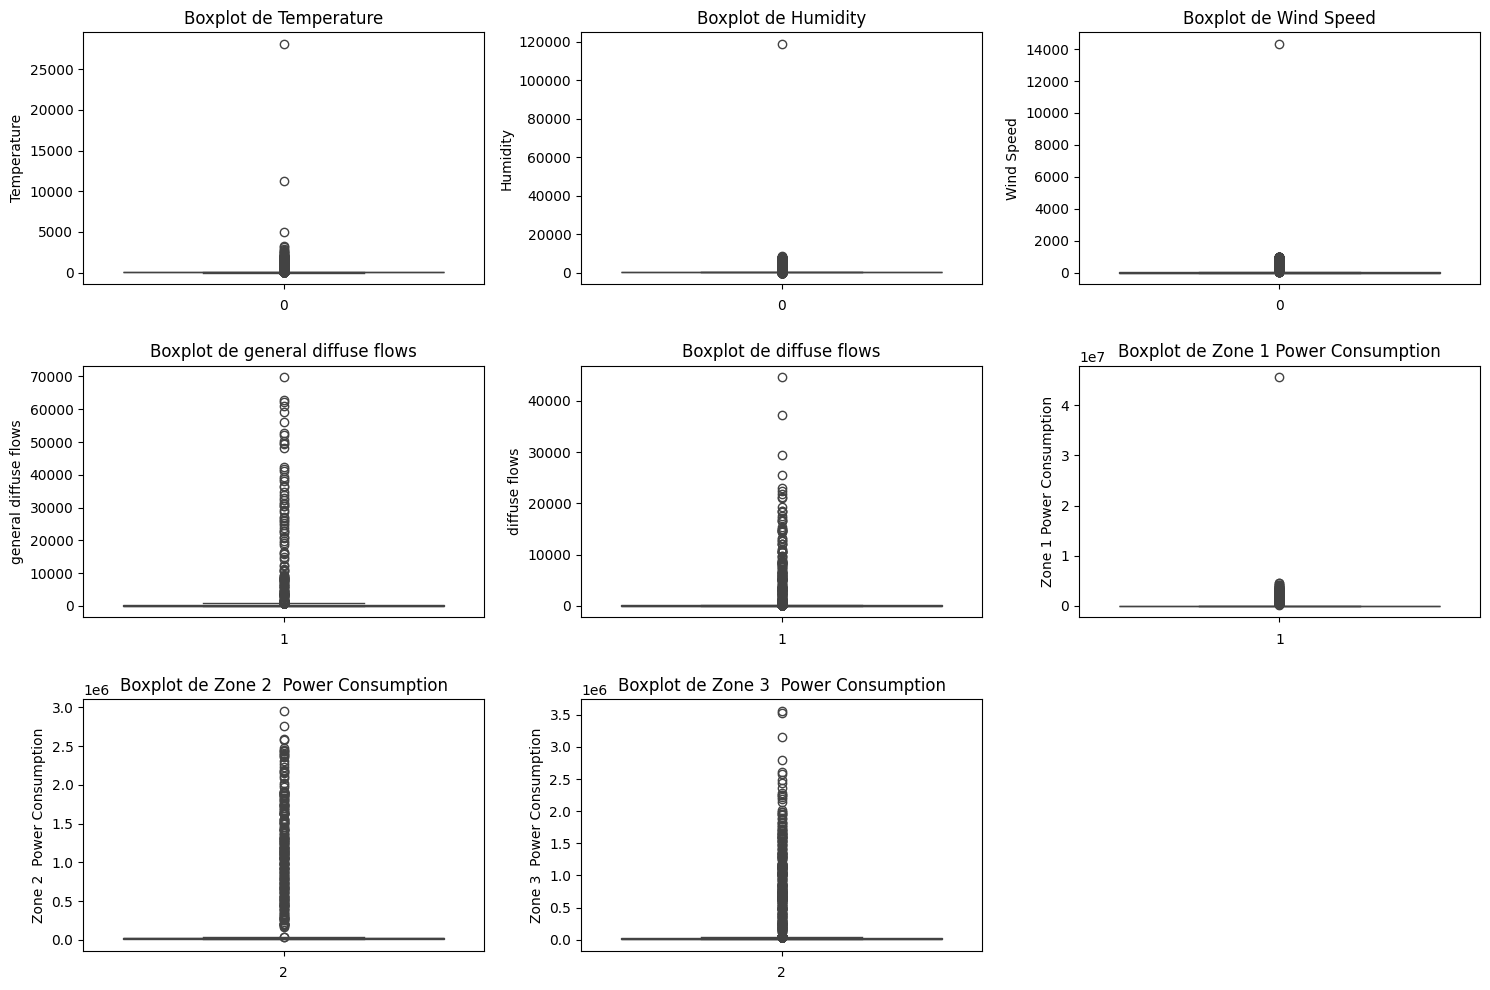

In [30]:
numeric_vars = df_modificada_sin_mixed.select_dtypes(include=['int64', 'float64'])
num_cols = 3
num_rows = (len(numeric_vars.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i, column in enumerate(numeric_vars.columns):
    row = i // num_cols
    col = i % num_cols   
    sns.boxplot(data=df_modificada_sin_mixed, y=column, ax=axes[row, col], color="#A011CE")
    axes[row, col].set_title(f'Boxplot de {column}')
    axes[row, col].set_xlabel(row)
    axes[row, col].set_ylabel(column)
    
for i in range(len(numeric_vars.columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
plt.show()

In [31]:
num_cols = df_modificada_sin_mixed.select_dtypes(include='number').columns
medianas = df_modificada_sin_mixed[num_cols].median()

df_imputado = df_modificada_sin_mixed.copy()
df_imputado[num_cols] = df_imputado[num_cols].fillna(medianas)

In [32]:
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52422 entries, 0 to 52421
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52418 non-null  datetime64[ns]
 1   Temperature                52422 non-null  float64       
 2   Humidity                   52422 non-null  float64       
 3   Wind Speed                 52422 non-null  float64       
 4   general diffuse flows      52422 non-null  float64       
 5   diffuse flows              52422 non-null  float64       
 6   Zone 1 Power Consumption   52422 non-null  float64       
 7   Zone 2  Power Consumption  52422 non-null  float64       
 8   Zone 3  Power Consumption  52422 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.6 MB


In [33]:
df_imputado.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52418,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,5.242200e+04,5.242200e+04,5.242200e+04
mean,2017-07-02 00:11:20.548666624,27.372810,91.774152,5.389908,221.808265,98.549844,4.236967e+04,2.618079e+04,2.271246e+04
min,2017-01-01 00:00:00,3.247000,11.340000,0.050000,0.004000,0.011000,1.389570e+04,8.560081e+03,5.935174e+03
25%,2017-04-02 00:42:30,14.510000,58.640000,0.078000,0.066000,0.122000,2.645526e+04,1.705909e+04,1.321841e+04
50%,2017-07-02 00:15:00,18.890000,70.100000,0.086000,6.158500,5.567000,3.232354e+04,2.085228e+04,1.644145e+04
75%,2017-09-30 23:57:30,22.980000,81.600000,4.915000,320.475000,101.800000,3.732308e+04,2.470610e+04,2.163615e+04
max,2017-12-30 23:50:00,28149.240000,118972.800000,14337.903000,69797.000000,44602.800000,4.559947e+07,2.958428e+06,3.566782e+06
std,NaN,162.761202,596.768802,76.892333,1201.217792,575.136269,2.462244e+05,8.710221e+04,8.240999e+04


In [34]:
df_original.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


In [36]:
df = df_imputado.sort_values('DateTime').copy()
num = df.select_dtypes('number').columns
# define outliers con IQR
Q1, Q3 = df[num].quantile(0.25), df[num].quantile(0.75)
IQR = Q3 - Q1
lo, hi = Q1 - 1.5*IQR, Q3 + 1.5*IQR
mask = (df[num] < lo) | (df[num] > hi)

# reemplaza por mediana local (ventana de 25; ajusta según tu frecuencia)
for c in num:
    rmed = df[c].rolling(window=25, center=True, min_periods=1).median()
    df.loc[mask[c], c] = rmed[mask[c]].fillna(df[c].median())

df_ts = df_imputado.sort_values('DateTime').reset_index(drop=True)

In [40]:
df.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52418,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000
mean,2017-07-02 00:11:20.548666624,18.815908,68.301284,1.942880,179.918948,65.060727,32352.355416,21041.805631,17794.021011
min,2017-01-01 00:00:00,3.247000,14.170000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,2017-04-02 00:42:30,14.470000,58.510000,0.078000,0.066000,0.122000,26422.468090,17043.177190,13193.005030
50%,2017-07-02 00:15:00,18.890000,70.100000,0.086000,6.158500,5.567000,32323.539820,20852.279640,16441.445780
75%,2017-09-30 23:57:30,22.817500,81.200000,4.915000,316.100000,97.900000,37219.441562,24633.224040,21477.570850
max,2017-12-30 23:50:00,39.440000,94.800000,8.742000,910.000000,776.000000,52204.395120,36129.250260,45447.364020
std,NaN,5.766445,15.407976,2.346301,260.195010,101.581029,7075.932012,5161.941869,6502.925092


In [38]:
df_original.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


# Preparación de Modelo

In [42]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52418 entries, 0 to 52305
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52418 non-null  datetime64[ns]
 1   Temperature                52418 non-null  float64       
 2   Humidity                   52418 non-null  float64       
 3   Wind Speed                 52418 non-null  float64       
 4   general diffuse flows      52418 non-null  float64       
 5   diffuse flows              52418 non-null  float64       
 6   Zone 1 Power Consumption   52418 non-null  float64       
 7   Zone 2  Power Consumption  52418 non-null  float64       
 8   Zone 3  Power Consumption  52418 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 4.0 MB


In [43]:
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df['Day of Week'] = df['DateTime'].dt.dayofweek + 1

In [44]:
def month_to_quarter(series):
    if series['Month'] <=3:
        return 1
    elif series['Month'] >3 and series['Month'] <=6:
        return 2
    elif series['Month'] >6 and series['Month'] <=9:
        return 3
    elif series['Month'] >9 and series['Month'] <=12:
        return 4

In [45]:
df['Quarter of Year'] = df.apply(month_to_quarter, axis='columns')

In [46]:
df['Day of Year'] = df['DateTime'].dt.strftime('%j').astype(int)  

In [47]:
df = df.drop(['DateTime'],axis=1)

In [ ]:
# Esta celda genera una nueva versión del archivo. Después de correr esta celda se necesita hacer el versionamiento del mismo, tanto en DVC como en GH.
# La idea es que esta celda la vayamos moviendo si vamos generando nuevas transformaciones/EDA que resulten en nuevos datasets.

df_final = df.copy()

df_final.to_csv(
    ruta_guardado,
    index=False,
    sep =','
)

In [49]:
df.columns=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3' ,'Day',
       'Month', 'Hour', 'Minute', 'DayWeek', 'QuarterYear',
       'DayYear']

In [50]:
df = df[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3' ,'Day',
       'Month', 'Hour', 'Minute', 'DayWeek', 'QuarterYear',
       'DayYear']]
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Day,Month,Hour,Minute,DayWeek,QuarterYear,DayYear
0,6.559,73.8,0.083,0.051,5.567,34055.69620,16128.87538,20240.96386,1,1,0,0,7,1,1
1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,1,1,0,10,7,1,1
2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,1,1,0,20,7,1,1
3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,1,1,0,30,7,1,1
4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,1,1,0,40,7,1,1


## Análisis de correlación

<Axes: >

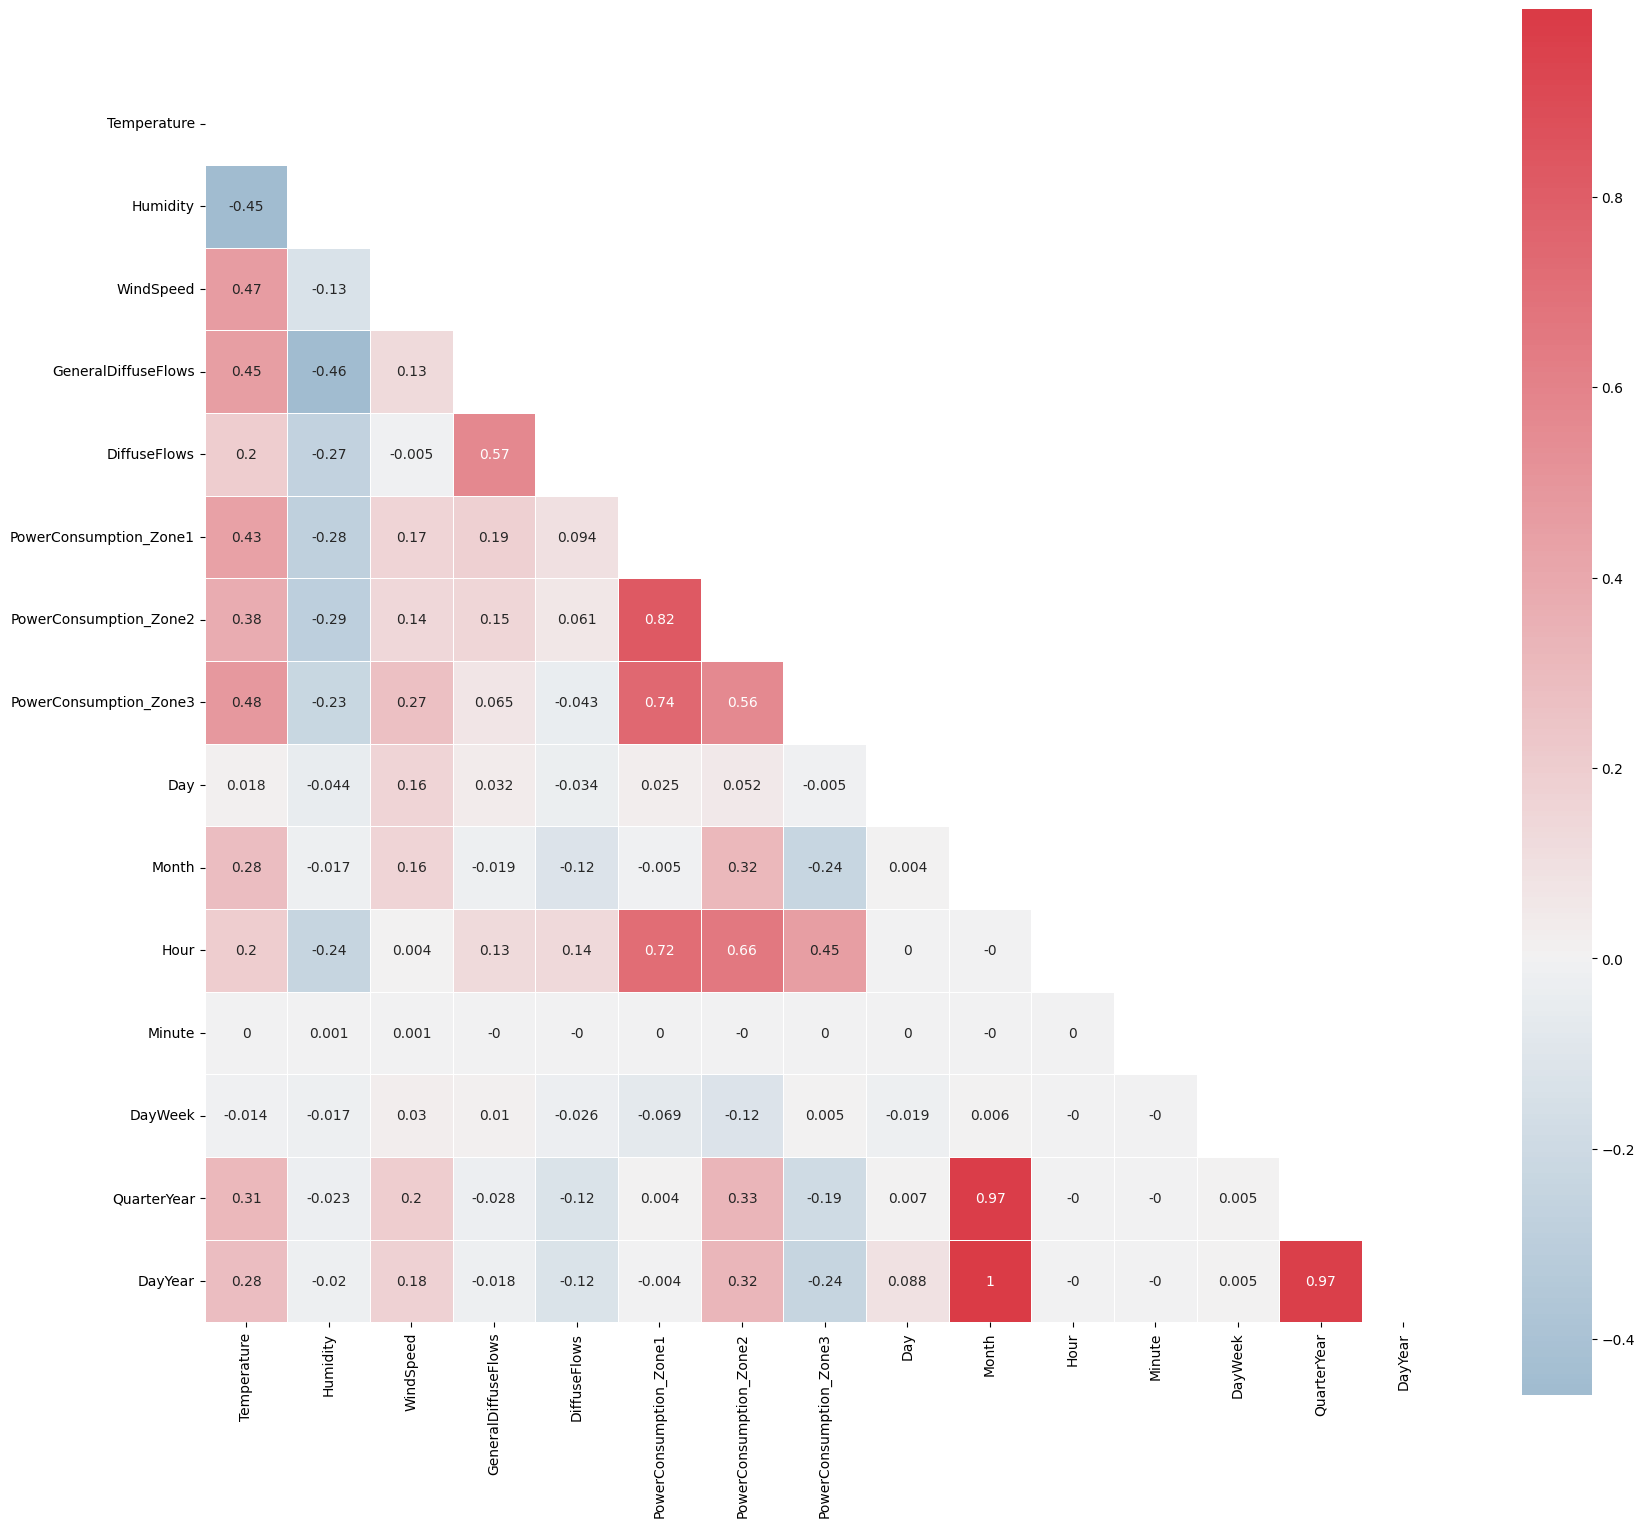

In [51]:
corr = df.corr().round(decimals=3)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

## Separación de variables y datasets de entrenamiento y pruebas

In [52]:
X=df.drop(columns=['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'])
Y=df[['PowerConsumption_Zone2']]

In [53]:
n = len(df_ts)
i = int(n * 0.80)

x_train, y_train = X.iloc[:i], Y.iloc[:i]
x_test,  y_test  = X.iloc[i:],  Y.iloc[i:]

## Aplicación de Modelos

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Transformaciones a factores numéricos de entrada:
num_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])
num_pipeline_nombres = ['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows']


#('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore')

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, num_pipeline_nombres)],
                                        remainder='passthrough')

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

def mis_modelos():
    modelos, nombres = list(), list()

    # RF - sin regularización explícita (como lo tenías)
    modelos.append(RandomForestRegressor(
        n_estimators=700,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=3,
        random_state=42,
        n_jobs=-1
    ))
    nombres.append('RF')

    return modelos, nombres

K fold aleatorio (no se recomienda mucho porque tiene aleatoriedad y pierde la temporalidad)

>> RF RMSE 864.706 (21.391)


/var/folders/vr/x3cn7k1n7v12_vr58fwzpfkr0000gn/T/ipykernel_2925/2325222785.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados, labels=nombres, showmeans=True)


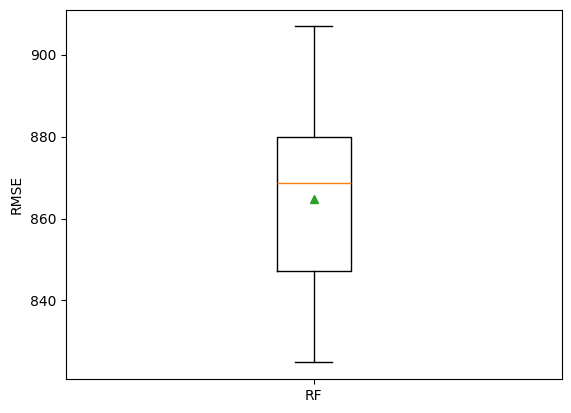

In [56]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

modelos, nombres = mis_modelos()
resultados = []

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=8)

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos[i])])

    # MSE negativo -> convierto a RMSE
    mse_scores = cross_val_score(pipeline, x_train, np.ravel(y_train),
                                 scoring='neg_mean_squared_error',
                                 cv=cv, n_jobs=-1)
    rmse_scores = np.sqrt(-mse_scores)

    resultados.append(rmse_scores)
    print(f">> {nombres[i]} RMSE {rmse_scores.mean():.3f} ({rmse_scores.std():.3f})")

plt.boxplot(resultados, labels=nombres, showmeans=True)
plt.ylabel("RMSE")
plt.show()

Entreno normal

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rf1 = RandomForestRegressor(n_estimators=700, min_samples_split=2, min_samples_leaf=1,max_features=3)

Xx = columnasTransformer.fit_transform(x_train)
mejor_result = rf1.fit(Xx, np.ravel(y_train))

X_test_t = columnasTransformer.transform(x_test)
y_true = np.ravel(y_test)
y_pred = mejor_result.predict(X_test_t)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # %

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.3f}%")

MSE:  13803700.083486
RMSE: 3715.333105
MAPE: 11.250%
